In [1]:
from ib_insync import *
from matplotlib import pyplot as plt
import math
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=3)

<IB connected to 127.0.0.1:7497 clientId=3>

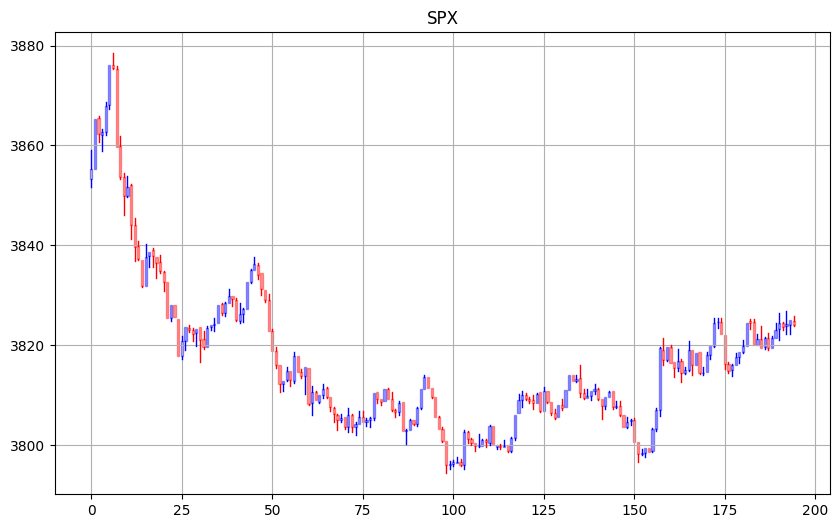

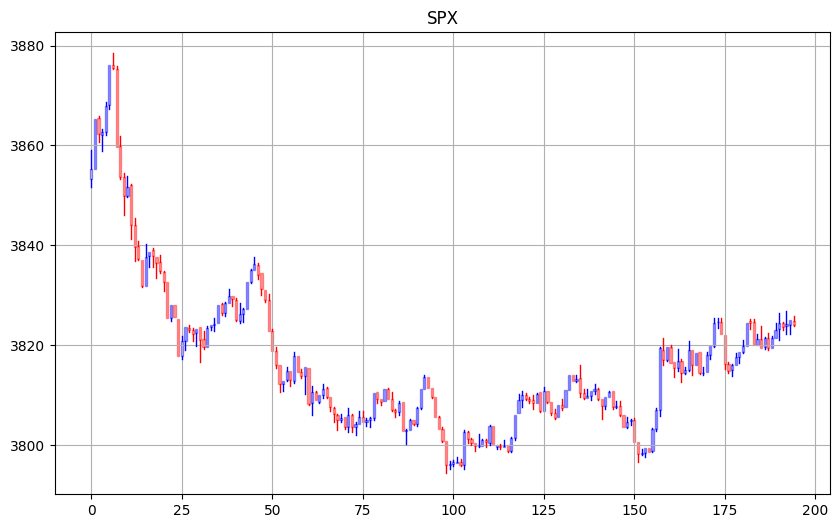

In [2]:
spx=Contract(symbol='SPX',secType='IND')
ib.qualifyContracts(spx)
ib.reqHeadTimeStamp(spx,whatToShow='TRADES', useRTH=True)
bars=ib.reqHistoricalData(
    contract=spx,
    endDateTime='',
    durationStr='1 D',
    barSizeSetting='2 mins',
    whatToShow='TRADES',
    useRTH=True,
    formatDate='1'
)
df=util.df(bars)
#plt.plot(df['close'])
util.barplot(bars, title=spx.symbol)

In [4]:
[ticker]=ib.reqTickers(spx)
spxVal=ticker.marketPrice()
if math.isnan(spxVal):
    spxVal=bars[-1].close
print('spx='+str(spxVal))
chains=ib.reqSecDefOptParams(spx.symbol,'',spx.secType, spx.conId)
#print('Chains='+str(chains))
chain=next(c for c in chains if c.tradingClass=='SPXW' and c.exchange=='SMART')
#print(chain)
strikes=[stk for stk in chain.strikes if stk%10==0 and spxVal-150<stk<spxVal-50]
expiration=sorted(exp for exp in chain.expirations)[:1]
rights=['P']
contracts=[Option('SPX',exp,stk,right,'SMART')
           for right in rights
           for exp in expiration
           for stk in strikes]

contracts=ib.qualifyContracts(*contracts)
print(contracts)
tickers=ib.reqTickers(*contracts)
#print(tickers)

spx=3824.07
[Option(conId=603761259, symbol='SPX', lastTradeDateOrContractMonth='20230104', strike=3680.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPXW  230104P03680000', tradingClass='SPXW'), Option(conId=603761264, symbol='SPX', lastTradeDateOrContractMonth='20230104', strike=3690.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPXW  230104P03690000', tradingClass='SPXW'), Option(conId=601322405, symbol='SPX', lastTradeDateOrContractMonth='20230104', strike=3700.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPXW  230104P03700000', tradingClass='SPXW'), Option(conId=601921374, symbol='SPX', lastTradeDateOrContractMonth='20230104', strike=3710.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPXW  230104P03710000', tradingClass='SPXW'), Option(conId=601921384, symbol='SPX', lastTradeDateOrContractMonth='20230104', strike=3720.0, right='P', multiplier='100', 

In [5]:
import spread_util
short_leg=[ticker for ticker in tickers if (ticker.lastGreeks.delta != None)\
           and(0.04<=abs(ticker.lastGreeks.delta)<=0.06)][0]
long_leg=[ticker for ticker in tickers if ticker.contract.strike==(short_leg.contract.strike-20)][0]
spread_price, stop_price=spread_util.calc_spread_price(ib,spread_util.SpreadType.BULLPUT,long_leg.contract,short_leg.contract,0,1)
spread_contract=spread_util.create_vertical_spread(long_leg.contract,short_leg.contract)
spread_order=LimitOrder('BUY',5,spread_price)
trade=ib.placeOrder(spread_contract,spread_order)
trade.log

[TradeLogEntry(time=datetime.datetime(2023, 1, 4, 7, 44, 10, 4044, tzinfo=datetime.timezone.utc), status='PendingSubmit', message='', errorCode=0)]

In [22]:
ib.disconnect()